In [4]:
import pandas as pd
import scipy.stats as stats
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler



df = pd.read_csv('/home/lenos/Desktop/NeuralNetworkProject/dataset-HAR-PUC-Rio.csv',delimiter=";",decimal=",")
#replace categorical with numerical values

df['gender'] = df['gender'].replace(['Woman'], '0')
df['gender'] = df['gender'].replace(['Man'], '1')

activities = df['class'].unique()
print(activities)
for count,value in enumerate(activities):
    df['class'] = df['class'].replace([value], count)

df= df.drop(['user'],axis=1)
#normilize numerical values
scaler = MinMaxScaler(feature_range=(0,1))
columns = ['age', 'how_tall_in_meters', 'weight', 'body_mass_index',
       'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       ]
#drop rows with empty columns
df= df.dropna()
df[columns] = df[columns].astype("float")
print(df.describe())
#apply normilizaiton and zscore
df[columns] = df[columns].apply(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).flatten())
df[columns] = df[columns].apply(stats.zscore)
df = df.sample(frac=1)
#create feature and label array
features= df[['gender', 'age', 'how_tall_in_meters', 'weight', 'body_mass_index',
       'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       ]].values
features = features.astype("float32")
labels = df['class'].values
p = pd.DataFrame(features,columns= ['gender', 'age', 'how_tall_in_meters', 'weight', 'body_mass_index',
       'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       ])
p.head()





['sitting' 'sittingdown' 'standing' 'standingup' 'walking']
                 age  how_tall_in_meters  ...             z4          class
count  165632.000000       165632.000000  ...  165632.000000  165632.000000
mean       38.264925            1.639712  ...    -159.650985       1.916109
std        13.183821            0.052820  ...      13.221020       1.552395
min        28.000000            1.580000  ...    -537.000000       0.000000
25%        28.000000            1.580000  ...    -167.000000       0.000000
50%        31.000000            1.620000  ...    -160.000000       2.000000
75%        46.000000            1.710000  ...    -153.000000       4.000000
max        75.000000            1.710000  ...     -43.000000       4.000000

[8 rows x 17 columns]


,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
0,0.0,-0.778602,-1.130475,-1.400381,-1.398149,-1.063226,-2.439490,1.780400,0.382612,0.127052,0.783417,0.200939,0.064313,0.195676,0.617083,-0.068846,-0.631497
1,1.0,-0.551050,1.330701,1.078258,0.738195,0.658502,-1.058495,0.790788,0.299985,0.131926,0.762671,1.017879,-0.748157,-0.333080,2.131000,-2.522700,-0.253311
2,0.0,0.586711,-0.373190,0.370076,0.804956,-0.804966,0.908377,-0.198825,0.482946,0.702214,0.275161,-0.065042,0.618270,0.041455,0.486573,-1.120498,0.578700
3,0.0,0.586711,-0.373190,0.370076,0.804956,0.228070,0.699136,-0.148075,0.547867,0.677843,0.269975,0.124944,0.064313,-0.046671,-0.322589,0.181547,-0.026399
4,1.0,-0.551050,1.330701,1.078258,0.738195,-0.460621,0.155107,-1.061564,0.429828,0.687592,0.254416,0.086947,0.285896,0.173644,-0.192079,0.682333,0.578700


In [5]:
from sklearn.model_selection import StratifiedKFold
from statistics import mean
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.optimizers import SGD

def average_history(histories):
    # Initialize an empty dictionary to hold the average values
    avg_history = {}
    
    # Loop over each epoch in the first history dictionary
    for epoch in histories[0]:
        # Initialize a dictionary to hold the sum of the values for the current epoch
        epoch_sum = {}
        
        # Loop over each history dictionary and sum the values for the current epoch
        for history in histories:
            for metric in history[epoch]:
                epoch_sum[metric] = epoch_sum.get(metric, 0) + history[epoch][metric]
        
        # Compute the average for each metric and add it to the average history dictionary
        avg_epoch = {metric: epoch_sum[metric] / len(histories) for metric in epoch_sum}
        avg_history[epoch] = avg_epoch
    
    return avg_history

def runModels(loss_in,metric_for_test,num_of_neurons = 17):
    # Create a sequential model

    def createModel():
        model = Sequential()
        # Add a hidden layer with 32 units and a ReLU activation function
        model.add(Dense(num_of_neurons, input_shape=(17,), activation='relu'))
        # Add an output layer with 5 units and a softmax activation function
        model.add(Dense(5, activation='softmax'))  
        # Compile the model with categorical crossentropy loss and sgd optimizer
        model.compile(loss=loss_in, optimizer=SGD(learning_rate=0.001),metrics=metric_for_test)
        return model


    skf = StratifiedKFold(n_splits=5)
    lst_accu_stratified = []
    history_list = []
    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=0)
    for train_index, test_index in skf.split(features, labels): 
        X_train_fold, X_test_fold = features[train_index], features[test_index] 
        y_train_fold, y_test_fold = labels[train_index], labels[test_index] 
       
        y_train_fold = to_categorical(y_train_fold) 
        y_test_fold = to_categorical(y_test_fold) 
        model=createModel()
        history=(model.fit(X_train_fold, y_train_fold,epochs=20,validation_split=0.1,callbacks=[early_stop]) )
        lst_accu_stratified.append(model.evaluate(X_test_fold, y_test_fold))
    # Append the metrics for this fold to the history list
        history_list.append(history)

    #model.save("model "+str(num_of_neurons))
    return history_list,lst_accu_stratified
loss = "categorical_crossentropy"
metric_for_test=[metrics.MeanSquaredError(),
                        metrics.CategoricalAccuracy(),
                        ]

In [6]:


history,models_acc=runModels(loss,metric_for_test,5)

history1,models_acc1=runModels(loss,metric_for_test,11)
history2,models_acc2=runModels(loss,metric_for_test,22)


Epoch 1/20
3727/3727 [==============================] - 7s 2ms/step - loss: 1.4576 - mean_squared_error: 0.1427 - categorical_accuracy: 0.4511 - val_loss: 1.1480 - val_mean_squared_error: 0.1130 - val_categorical_accuracy: 0.7005
Epoch 2/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.9831 - mean_squared_error: 0.0964 - categorical_accuracy: 0.7227 - val_loss: 0.8836 - val_mean_squared_error: 0.0873 - val_categorical_accuracy: 0.7170
Epoch 3/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.8177 - mean_squared_error: 0.0813 - categorical_accuracy: 0.7238 - val_loss: 0.7808 - val_mean_squared_error: 0.0780 - val_categorical_accuracy: 0.7328
Epoch 4/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.7397 - mean_squared_error: 0.0741 - categorical_accuracy: 0.7414 - val_loss: 0.7197 - val_mean_squared_error: 0.0722 - val_categorical_accuracy: 0.7492
Epoch 5/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.68

In [7]:
import matplotlib.pyplot as plt
import numpy as np
def plot_avg_metrics(history_list):
    metrics = set()
    for history in history_list:
        metrics.update(history.history.keys())
    if 'epoch' in metrics:
        metrics.remove('epoch')
    
    avg_metrics = {metric: [] for metric in metrics}
    # Find minimum number of epochs across all histories
    num_epochs = np.min([len(history.history['loss']) for history in history_list])
    for epoch in range(num_epochs):
        epoch_metrics = {metric: [] for metric in metrics}
        for history in history_list:
            for metric in metrics:
                epoch_metrics[metric].append(history.history[metric][epoch])
        for metric in metrics:
            avg_metric = sum(epoch_metrics[metric]) / len(epoch_metrics[metric])
            avg_metrics[metric].append(avg_metric)
    
    for metric in avg_metrics:
        plt.plot(avg_metrics[metric], label=metric)

    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.xticks(range(num_epochs))
    plt.yticks([i/10 for i in range(21)])
    plt.xlim([0, num_epochs-1])
    plt.ylim([0, 1])
    plt.legend()
    plt.show()






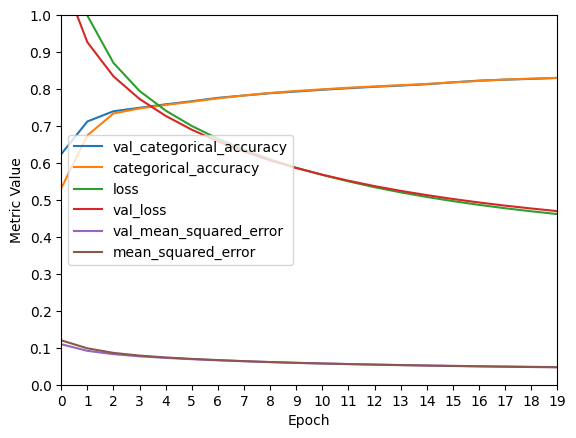

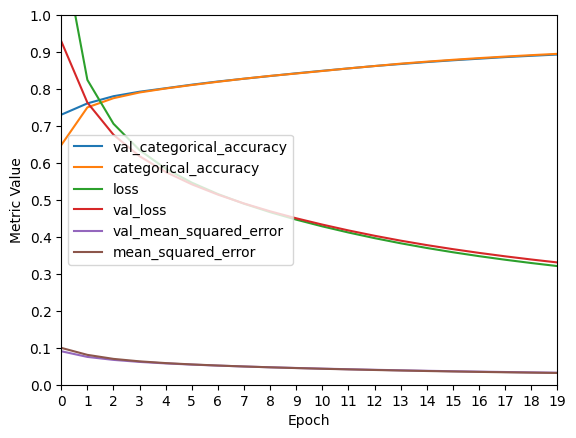

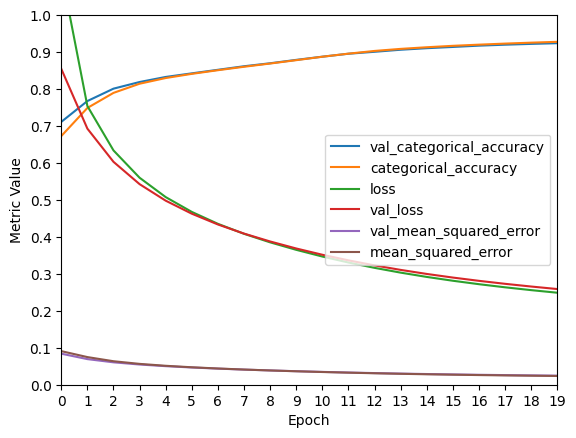

[0.46018901 0.04693603 0.83089616]
[0.31857923 0.03152292 0.89595619]
[0.24773031 0.02354609 0.92794265]


In [8]:
plot_avg_metrics(history)
plot_avg_metrics(history1)
plot_avg_metrics(history2)
print(np.mean(models_acc,axis=0))
print(np.mean(models_acc1,axis=0))
print(np.mean(models_acc2,axis=0))

In [9]:
def runModels2(metric_for_test,learning_rate,momentum):
     
    def createModel():
        model = Sequential()
        # Add a hidden layer with 32 units and a ReLU activation function
        model.add(Dense(22, input_shape=(17,), activation='relu'))
        # Add an output layer with 5 units and a softmax activation function
        model.add(Dense(5, activation='softmax'))  
        # Compile the model with categorical crossentropy loss and sgd optimizer
        sgd = SGD(lr=learning_rate, momentum=momentum)
        model.compile(loss=loss, optimizer=sgd,metrics=metric_for_test)
        return model
    skf = StratifiedKFold(n_splits=5)
    lst_accu_stratified = []
    history_list = []
    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=0)
    for train_index, test_index in skf.split(features, labels): 
        X_train_fold, X_test_fold = features[train_index], features[test_index] 
        y_train_fold, y_test_fold = labels[train_index], labels[test_index] 
        
        y_train_fold = to_categorical(y_train_fold) 
        y_test_fold = to_categorical(y_test_fold) 
        model=createModel()
        history=(model.fit(X_train_fold, y_train_fold,epochs=20,validation_split=0.1,callbacks=[early_stop]) )
        lst_accu_stratified.append(model.evaluate(X_test_fold, y_test_fold))
    # Append the metrics for this fold to the history list
        history_list.append(history)
    return history_list,lst_accu_stratified




Epoch 1/20


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 8s 2ms/step - loss: 1.0109 - mean_squared_error: 0.0829 - categorical_accuracy: 0.7057 - val_loss: 0.8003 - val_mean_squared_error: 0.0782 - val_categorical_accuracy: 0.7538
Epoch 2/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.7097 - mean_squared_error: 0.0699 - categorical_accuracy: 0.7721 - val_loss: 0.6587 - val_mean_squared_error: 0.0652 - val_categorical_accuracy: 0.7836
Epoch 3/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.5998 - mean_squared_error: 0.0597 - categorical_accuracy: 0.7983 - val_loss: 0.5717 - val_mean_squared_error: 0.0569 - val_categorical_accuracy: 0.8089
Epoch 4/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.5249 - mean_squared_error: 0.0524 - categorical_accuracy: 0.8245 - val_loss: 0.5089 - val_mean_squared_error: 0.0506 - val_categorical_accuracy: 0.8319
Epoch 5/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.4696 - mean_s

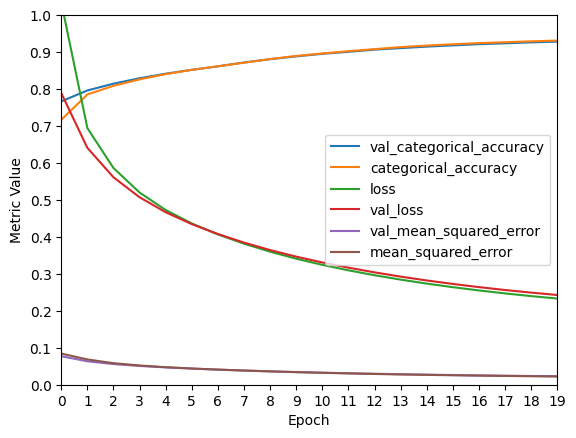

[0.23219647 0.02212146 0.93156518]
Epoch 1/20


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 7s 2ms/step - loss: 0.8716 - mean_squared_error: 0.0717 - categorical_accuracy: 0.7635 - val_loss: 0.6590 - val_mean_squared_error: 0.0656 - val_categorical_accuracy: 0.7865
Epoch 2/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.5619 - mean_squared_error: 0.0562 - categorical_accuracy: 0.8129 - val_loss: 0.5113 - val_mean_squared_error: 0.0513 - val_categorical_accuracy: 0.8255
Epoch 3/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.4582 - mean_squared_error: 0.0459 - categorical_accuracy: 0.8418 - val_loss: 0.4372 - val_mean_squared_error: 0.0437 - val_categorical_accuracy: 0.8508
Epoch 4/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.3971 - mean_squared_error: 0.0396 - categorical_accuracy: 0.8670 - val_loss: 0.3862 - val_mean_squared_error: 0.0383 - val_categorical_accuracy: 0.8784
Epoch 5/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.3525 - mean_s

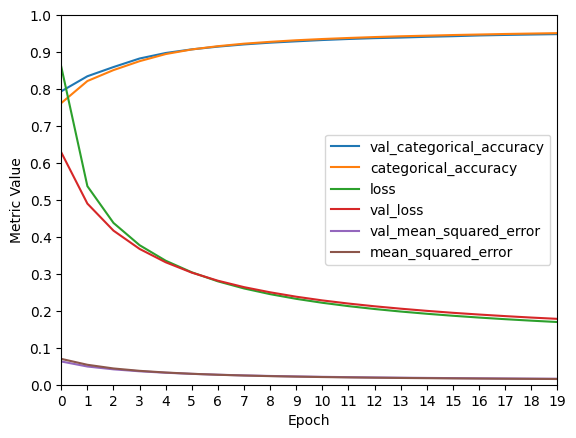

[0.16976827 0.01547544 0.95123526]
Epoch 1/20


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 8s 2ms/step - loss: 0.2084 - mean_squared_error: 0.0187 - categorical_accuracy: 0.9402 - val_loss: 0.1420 - val_mean_squared_error: 0.0129 - val_categorical_accuracy: 0.9605
Epoch 2/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.1155 - mean_squared_error: 0.0104 - categorical_accuracy: 0.9670 - val_loss: 0.1175 - val_mean_squared_error: 0.0101 - val_categorical_accuracy: 0.9686
Epoch 3/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.0991 - mean_squared_error: 0.0088 - categorical_accuracy: 0.9721 - val_loss: 0.0951 - val_mean_squared_error: 0.0083 - val_categorical_accuracy: 0.9731
Epoch 4/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.0912 - mean_squared_error: 0.0080 - categorical_accuracy: 0.9751 - val_loss: 0.0938 - val_mean_squared_error: 0.0081 - val_categorical_accuracy: 0.9748
Epoch 5/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.0861 - mean_s

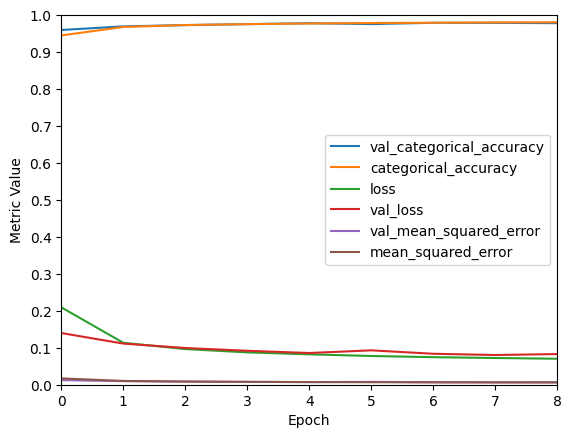

[0.07201551 0.0060706  0.98105438]
Epoch 1/20


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 8s 2ms/step - loss: 0.1826 - mean_squared_error: 0.0144 - categorical_accuracy: 0.9539 - val_loss: 0.1149 - val_mean_squared_error: 0.0098 - val_categorical_accuracy: 0.9689
Epoch 2/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.1040 - mean_squared_error: 0.0089 - categorical_accuracy: 0.9714 - val_loss: 0.1198 - val_mean_squared_error: 0.0108 - val_categorical_accuracy: 0.9650
Epoch 3/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.0914 - mean_squared_error: 0.0079 - categorical_accuracy: 0.9746 - val_loss: 0.1097 - val_mean_squared_error: 0.0085 - val_categorical_accuracy: 0.9725
Epoch 4/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.0864 - mean_squared_error: 0.0074 - categorical_accuracy: 0.9765 - val_loss: 0.1274 - val_mean_squared_error: 0.0085 - val_categorical_accuracy: 0.9726
Epoch 5/20
3727/3727 [==============================] - 7s 2ms/step - loss: 0.0828 - mean_s

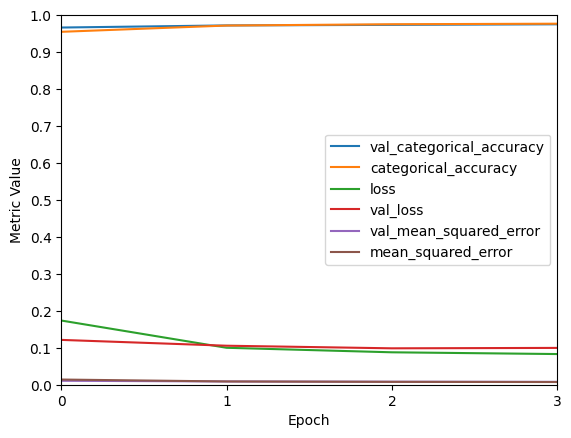

[0.08011002 0.00667932 0.97883258]


In [10]:
history,models_acc=runModels2(metric_for_test,0.001,0.2)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModels2(metric_for_test,0.001,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModels2(metric_for_test,0.05,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModels2(metric_for_test,0.1,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))


In [11]:
from keras.regularizers import l2
def runModels3(metric_for_test,learning_rate,momentum,r):
     
    def createModel():
        model = Sequential()
        # Add a hidden layer with 32 units and a ReLU activation function
        model.add(Dense(22, input_shape=(17,), activation='relu',kernel_regularizer=l2(r)))
        # Add an output layer with 5 units and a softmax activation function
        model.add(Dense(5, activation='softmax'))  
        # Compile the model with categorical crossentropy loss and sgd optimizer
        sgd = SGD(lr=learning_rate, momentum=momentum)
        model.compile(loss=loss, optimizer=sgd,metrics=metric_for_test)
        return model
    skf = StratifiedKFold(n_splits=5)
    lst_accu_stratified = []
    history_list = []
    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=0)
    for train_index, test_index in skf.split(features, labels): 
        X_train_fold, X_test_fold = features[train_index], features[test_index] 
        y_train_fold, y_test_fold = labels[train_index], labels[test_index] 
        
        y_train_fold = to_categorical(y_train_fold) 
        y_test_fold = to_categorical(y_test_fold) 
        model=createModel()
        history=(model.fit(X_train_fold, y_train_fold,epochs=20) )
        lst_accu_stratified.append(model.evaluate(X_test_fold, y_test_fold))
    # Append the metrics for this fold to the history list
        history_list.append(history)
    return history_list,lst_accu_stratified



Epoch 1/20


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4141/4141 [==============================] - 8s 2ms/step - loss: 0.7203 - mean_squared_error: 0.0447 - categorical_accuracy: 0.8466
Epoch 2/20
4141/4141 [==============================] - 7s 2ms/step - loss: 0.7079 - mean_squared_error: 0.0510 - categorical_accuracy: 0.8251
Epoch 3/20
4141/4141 [==============================] - 7s 2ms/step - loss: 0.7148 - mean_squared_error: 0.0514 - categorical_accuracy: 0.8243
Epoch 4/20
4141/4141 [==============================] - 7s 2ms/step - loss: 0.7201 - mean_squared_error: 0.0520 - categorical_accuracy: 0.8205
Epoch 5/20
4141/4141 [==============================] - 7s 2ms/step - loss: 0.7304 - mean_squared_error: 0.0545 - categorical_accuracy: 0.8112
Epoch 6/20
4141/4141 [==============================] - 7s 2ms/step - loss: 0.7332 - mean_squared_error: 0.0546 - categorical_accuracy: 0.8111
Epoch 7/20
4141/4141 [==============================] - 7s 2ms/step - loss: 0.7443 - mean_squared_error: 0.0559 - categorical_accuracy: 0.8060
Epoch 8/20

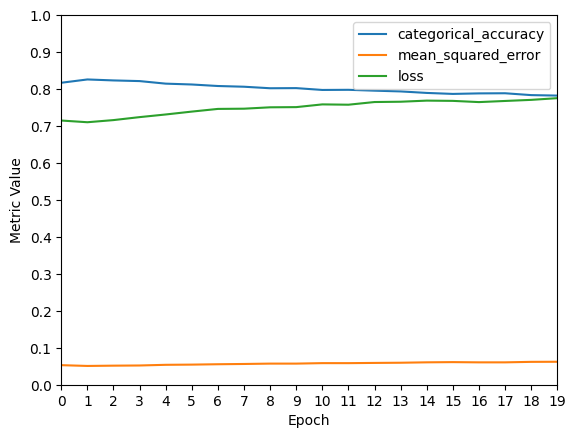

[0.74401612 0.05880793 0.79581248]
Epoch 1/20


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4141/4141 [==============================] - 8s 2ms/step - loss: 1.0339 - mean_squared_error: 0.0744 - categorical_accuracy: 0.7407
Epoch 2/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.0454 - mean_squared_error: 0.0793 - categorical_accuracy: 0.7161
Epoch 3/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.0446 - mean_squared_error: 0.0800 - categorical_accuracy: 0.7134
Epoch 4/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.0552 - mean_squared_error: 0.0802 - categorical_accuracy: 0.7116
Epoch 5/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.0500 - mean_squared_error: 0.0804 - categorical_accuracy: 0.7124
Epoch 6/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.0685 - mean_squared_error: 0.0808 - categorical_accuracy: 0.7112
Epoch 7/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.0428 - mean_squared_error: 0.0810 - categorical_accuracy: 0.7109
Epoch 8/20

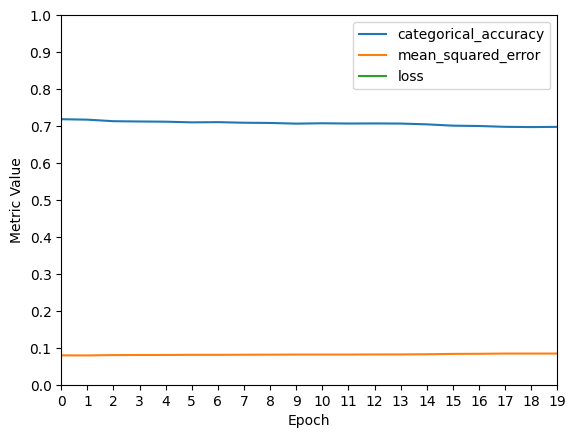

[1.06956658 0.08409981 0.70209854]
Epoch 1/20


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4141/4141 [==============================] - 7s 2ms/step - loss: 1.1716 - mean_squared_error: 0.0862 - categorical_accuracy: 0.6941
Epoch 2/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.1752 - mean_squared_error: 0.0872 - categorical_accuracy: 0.6842
Epoch 3/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.1654 - mean_squared_error: 0.0877 - categorical_accuracy: 0.6837
Epoch 4/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.1894 - mean_squared_error: 0.0880 - categorical_accuracy: 0.6804
Epoch 5/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.1919 - mean_squared_error: 0.0883 - categorical_accuracy: 0.6795
Epoch 6/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.2217 - mean_squared_error: 0.0886 - categorical_accuracy: 0.6782
Epoch 7/20
4141/4141 [==============================] - 7s 2ms/step - loss: 1.2105 - mean_squared_error: 0.0886 - categorical_accuracy: 0.6797
Epoch 8/20

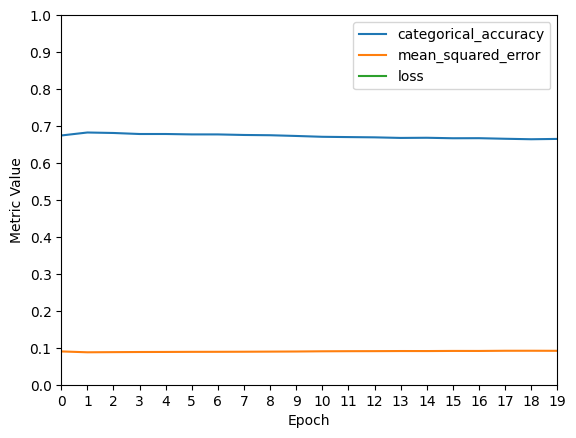

[1.26621623 0.10225382 0.61752517]


In [12]:
history,models_acc=runModels3(metric_for_test,0.1,0.6,0.1)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModels3(metric_for_test,0.1,0.6,0.5)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModels3(metric_for_test,0.1,0.6,0.9)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))

In [15]:
def runModeldeep1(metric_for_test,learning_rate,momentum):
     
    def createModel():
        model = Sequential()
        # Add a hidden layer with 32 units and a ReLU activation function
        model.add(Dense(22, input_shape=(17,), activation='relu'))
        model.add(Dense(22, activation='relu'))
        model.add(Dense(22, activation='relu'))
        # Add an output layer with 5 units and a softmax activation function
        model.add(Dense(5, activation='softmax'))  
        # Compile the model with categorical crossentropy loss and sgd optimizer
        sgd = SGD(lr=learning_rate, momentum=momentum)
        model.compile(loss=loss, optimizer=sgd,metrics=metric_for_test)
        return model
    skf = StratifiedKFold(n_splits=5)
    lst_accu_stratified = []
    history_list = []
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
    for train_index, test_index in skf.split(features, labels): 
        X_train_fold, X_test_fold = features[train_index], features[test_index] 
        y_train_fold, y_test_fold = labels[train_index], labels[test_index] 
        
        y_train_fold = to_categorical(y_train_fold) 
        y_test_fold = to_categorical(y_test_fold) 
        model=createModel()
        history=(model.fit(X_train_fold, y_train_fold,epochs=30,validation_split=0.1,callbacks=[early_stop]) )
        lst_accu_stratified.append(model.evaluate(X_test_fold, y_test_fold))
    # Append the metrics for this fold to the history list
        history_list.append(history)
    return history_list,lst_accu_stratified

def runModeldeep2(metric_for_test,learning_rate,momentum):
     
    def createModel():
        model = Sequential()
        # Add a hidden layer with 32 units and a ReLU activation function
        model.add(Dense(22, input_shape=(17,), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        # Add an output layer with 5 units and a softmax activation function
        model.add(Dense(5, activation='softmax'))  
        # Compile the model with categorical crossentropy loss and sgd optimizer
        sgd = SGD(lr=learning_rate, momentum=momentum)
        model.compile(loss=loss, optimizer=sgd,metrics=metric_for_test)
        return model
    skf = StratifiedKFold(n_splits=5)
    lst_accu_stratified = []
    history_list = []
    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=0)
    for train_index, test_index in skf.split(features, labels): 
        X_train_fold, X_test_fold = features[train_index], features[test_index] 
        y_train_fold, y_test_fold = labels[train_index], labels[test_index] 
        
        y_train_fold = to_categorical(y_train_fold) 
        y_test_fold = to_categorical(y_test_fold) 
        model=createModel()
        history=(model.fit(X_train_fold, y_train_fold,epochs=30,validation_split=0.1,callbacks=[early_stop]) )
        lst_accu_stratified.append(model.evaluate(X_test_fold, y_test_fold))
    # Append the metrics for this fold to the history list
        history_list.append(history)
    return history_list,lst_accu_stratified

def runModeldeep3(metric_for_test,learning_rate,momentum):
     
    def createModel():
        model = Sequential()
        # Add a hidden layer with 32 units and a ReLU activation function
        model.add(Dense(22, input_shape=(17,), activation='relu'))
        model.add(Dense(11, activation='relu'))
        model.add(Dense(11, activation='relu'))
        # Add an output layer with 5 units and a softmax activation function
        model.add(Dense(5, activation='softmax'))  
        # Compile the model with categorical crossentropy loss and sgd optimizer
        sgd = SGD(lr=learning_rate, momentum=momentum)
        model.compile(loss=loss, optimizer=sgd,metrics=metric_for_test)
        return model
    skf = StratifiedKFold(n_splits=5)
    lst_accu_stratified = []
    history_list = []
    early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0)
    for train_index, test_index in skf.split(features, labels): 
        X_train_fold, X_test_fold = features[train_index], features[test_index] 
        y_train_fold, y_test_fold = labels[train_index], labels[test_index] 
        
        y_train_fold = to_categorical(y_train_fold) 
        y_test_fold = to_categorical(y_test_fold) 
        model=createModel()
        history=(model.fit(X_train_fold, y_train_fold,epochs=30,validation_split=0.1,callbacks=[early_stop]) )
        lst_accu_stratified.append(model.evaluate(X_test_fold, y_test_fold))
    # Append the metrics for this fold to the history list
        history_list.append(history)
    return history_list,lst_accu_stratified

Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 9s 2ms/step - loss: 0.8876 - mean_squared_error: 0.0907 - categorical_accuracy: 0.7059 - val_loss: 0.6144 - val_mean_squared_error: 0.0614 - val_categorical_accuracy: 0.7920
Epoch 2/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.4964 - mean_squared_error: 0.0496 - categorical_accuracy: 0.8257 - val_loss: 0.4278 - val_mean_squared_error: 0.0429 - val_categorical_accuracy: 0.8411
Epoch 3/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.3634 - mean_squared_error: 0.0363 - categorical_accuracy: 0.8692 - val_loss: 0.3314 - val_mean_squared_error: 0.0331 - val_categorical_accuracy: 0.8874
Epoch 4/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.2831 - mean_squared_error: 0.0278 - categorical_accuracy: 0.9089 - val_loss: 0.2630 - val_mean_squared_error: 0.0252 - val_categorical_accuracy: 0.9208
Epoch 5/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.2263 - mean_s

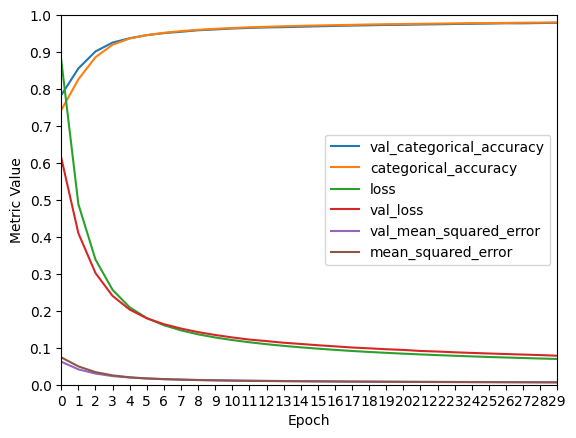

[0.07382225 0.00647367 0.97954502]
Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 9s 2ms/step - loss: 0.3142 - mean_squared_error: 0.0254 - categorical_accuracy: 0.9165 - val_loss: 0.1514 - val_mean_squared_error: 0.0135 - val_categorical_accuracy: 0.9572
Epoch 2/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.1198 - mean_squared_error: 0.0106 - categorical_accuracy: 0.9665 - val_loss: 0.1064 - val_mean_squared_error: 0.0097 - val_categorical_accuracy: 0.9691
Epoch 3/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0928 - mean_squared_error: 0.0083 - categorical_accuracy: 0.9737 - val_loss: 0.0869 - val_mean_squared_error: 0.0075 - val_categorical_accuracy: 0.9763
Epoch 4/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0801 - mean_squared_error: 0.0073 - categorical_accuracy: 0.9773 - val_loss: 0.0752 - val_mean_squared_error: 0.0067 - val_categorical_accuracy: 0.9791
Epoch 5/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0710 - mean_s

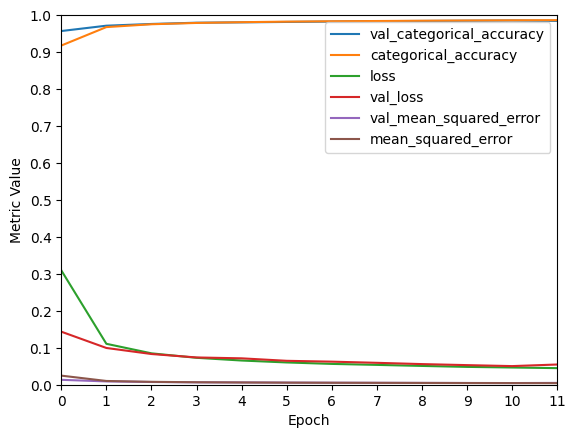

[0.04709271 0.00421092 0.9867175 ]
Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 9s 2ms/step - loss: 0.1544 - mean_squared_error: 0.0126 - categorical_accuracy: 0.9591 - val_loss: 0.1191 - val_mean_squared_error: 0.0110 - val_categorical_accuracy: 0.9637
Epoch 2/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0843 - mean_squared_error: 0.0080 - categorical_accuracy: 0.9742 - val_loss: 0.0675 - val_mean_squared_error: 0.0064 - val_categorical_accuracy: 0.9795
Epoch 3/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0717 - mean_squared_error: 0.0068 - categorical_accuracy: 0.9786 - val_loss: 0.0634 - val_mean_squared_error: 0.0059 - val_categorical_accuracy: 0.9810
Epoch 4/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0646 - mean_squared_error: 0.0061 - categorical_accuracy: 0.9806 - val_loss: 0.0765 - val_mean_squared_error: 0.0078 - val_categorical_accuracy: 0.9741
Epoch 5/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0592 - mean_s

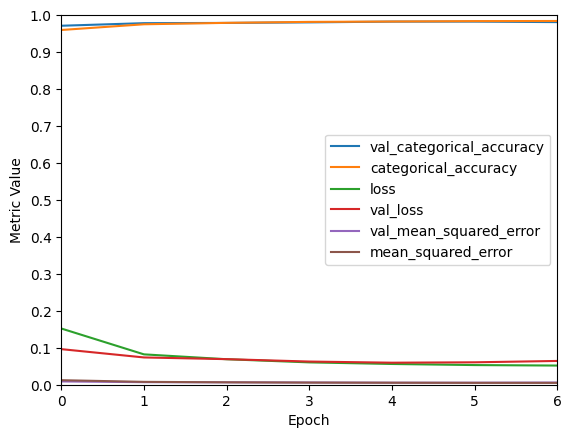

[0.05012221 0.00440176 0.98606551]


In [14]:
history,models_acc=runModeldeep1(metric_for_test,0.001,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModeldeep1(metric_for_test,0.01,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModeldeep1(metric_for_test,0.1,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
3727/3727 [==============================] - 12s 3ms/step - loss: 1.0124 - mean_squared_error: 0.0788 - categorical_accuracy: 0.7761 - val_loss: 0.6151 - val_mean_squared_error: 0.0585 - val_categorical_accuracy: 0.8045
Epoch 2/30
3727/3727 [==============================] - 11s 3ms/step - loss: 0.4516 - mean_squared_error: 0.0439 - categorical_accuracy: 0.8505 - val_loss: 0.3727 - val_mean_squared_error: 0.0366 - val_categorical_accuracy: 0.8808
Epoch 3/30
3727/3727 [==============================] - 10s 3ms/step - loss: 0.3217 - mean_squared_error: 0.0316 - categorical_accuracy: 0.8969 - val_loss: 0.3008 - val_mean_squared_error: 0.0292 - val_categorical_accuracy: 0.9088
Epoch 4/30
3727/3727 [==============================] - 11s 3ms/step - loss: 0.2642 - mean_squared_error: 0.0256 - categorical_accuracy: 0.9183 - val_loss: 0.2517 - val_mean_squared_error: 0.0242 - val_categorical_accuracy: 0.9245
Epoch 5/30
3727/3727 [==============================] - 9s 3ms/step - loss: 

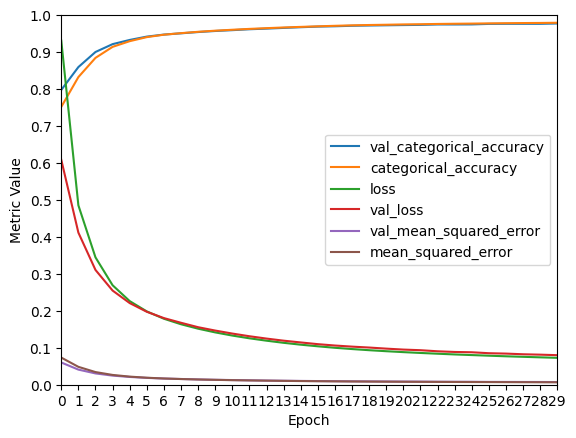

[0.07703213 0.0069072  0.97848845]
Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 10s 2ms/step - loss: 0.3370 - mean_squared_error: 0.0275 - categorical_accuracy: 0.9037 - val_loss: 0.1574 - val_mean_squared_error: 0.0144 - val_categorical_accuracy: 0.9561
Epoch 2/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.1177 - mean_squared_error: 0.0104 - categorical_accuracy: 0.9669 - val_loss: 0.1345 - val_mean_squared_error: 0.0126 - val_categorical_accuracy: 0.9592
Epoch 3/30
3727/3727 [==============================] - 9s 2ms/step - loss: 0.0903 - mean_squared_error: 0.0080 - categorical_accuracy: 0.9746 - val_loss: 0.0950 - val_mean_squared_error: 0.0085 - val_categorical_accuracy: 0.9734
Epoch 4/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0777 - mean_squared_error: 0.0069 - categorical_accuracy: 0.9782 - val_loss: 0.0739 - val_mean_squared_error: 0.0069 - val_categorical_accuracy: 0.9777
Epoch 5/30
3727/3727 [==============================] - 9s 2ms/step - loss: 0.0694 - mean_

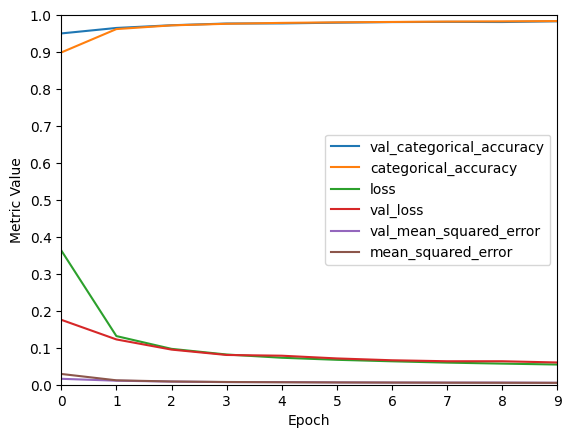

[0.05519368 0.00501448 0.98397651]
Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 10s 2ms/step - loss: 0.1523 - mean_squared_error: 0.0123 - categorical_accuracy: 0.9593 - val_loss: 0.0852 - val_mean_squared_error: 0.0074 - val_categorical_accuracy: 0.9771
Epoch 2/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0809 - mean_squared_error: 0.0075 - categorical_accuracy: 0.9761 - val_loss: 0.0720 - val_mean_squared_error: 0.0067 - val_categorical_accuracy: 0.9789
Epoch 3/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0700 - mean_squared_error: 0.0064 - categorical_accuracy: 0.9801 - val_loss: 0.0692 - val_mean_squared_error: 0.0061 - val_categorical_accuracy: 0.9813
Epoch 4/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0641 - mean_squared_error: 0.0059 - categorical_accuracy: 0.9813 - val_loss: 0.0601 - val_mean_squared_error: 0.0056 - val_categorical_accuracy: 0.9820
Epoch 5/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0590 - mean_

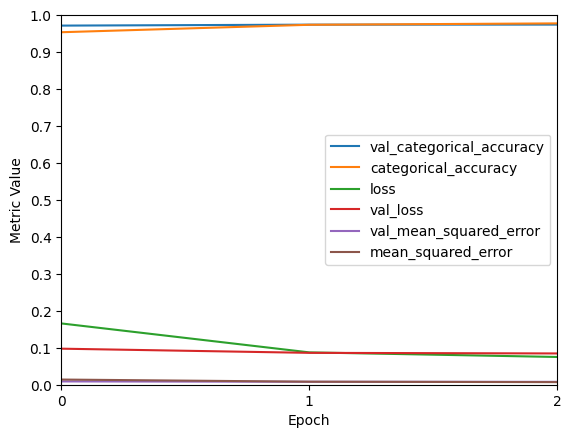

[0.08509488 0.00813236 0.97347134]
Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 9s 2ms/step - loss: 1.0770 - mean_squared_error: 0.0852 - categorical_accuracy: 0.6703 - val_loss: 0.7296 - val_mean_squared_error: 0.0733 - val_categorical_accuracy: 0.7586
Epoch 2/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.5911 - mean_squared_error: 0.0595 - categorical_accuracy: 0.7938 - val_loss: 0.4950 - val_mean_squared_error: 0.0491 - val_categorical_accuracy: 0.8300
Epoch 3/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.4145 - mean_squared_error: 0.0410 - categorical_accuracy: 0.8571 - val_loss: 0.3734 - val_mean_squared_error: 0.0371 - val_categorical_accuracy: 0.8685
Epoch 4/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.3293 - mean_squared_error: 0.0324 - categorical_accuracy: 0.8874 - val_loss: 0.3115 - val_mean_squared_error: 0.0306 - val_categorical_accuracy: 0.9010
Epoch 5/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.2777 - mean_s

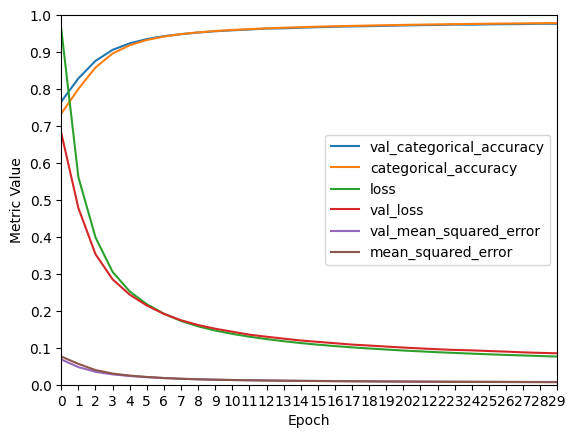

[0.07802543 0.00705227 0.97764921]
Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3727/3727 [==============================] - 19s 5ms/step - loss: 0.3038 - mean_squared_error: 0.0248 - categorical_accuracy: 0.9195 - val_loss: 0.1537 - val_mean_squared_error: 0.0140 - val_categorical_accuracy: 0.9550
Epoch 2/30
3727/3727 [==============================] - 9s 2ms/step - loss: 0.1212 - mean_squared_error: 0.0112 - categorical_accuracy: 0.9639 - val_loss: 0.1112 - val_mean_squared_error: 0.0105 - val_categorical_accuracy: 0.9645
Epoch 3/30
3727/3727 [==============================] - 9s 2ms/step - loss: 0.0959 - mean_squared_error: 0.0089 - categorical_accuracy: 0.9714 - val_loss: 0.0907 - val_mean_squared_error: 0.0083 - val_categorical_accuracy: 0.9735
Epoch 4/30
3727/3727 [==============================] - 8s 2ms/step - loss: 0.0818 - mean_squared_error: 0.0075 - categorical_accuracy: 0.9758 - val_loss: 0.0783 - val_mean_squared_error: 0.0071 - val_categorical_accuracy: 0.9778
Epoch 5/30
3727/3727 [==============================] - 9s 2ms/step - loss: 0.0742 - mean_

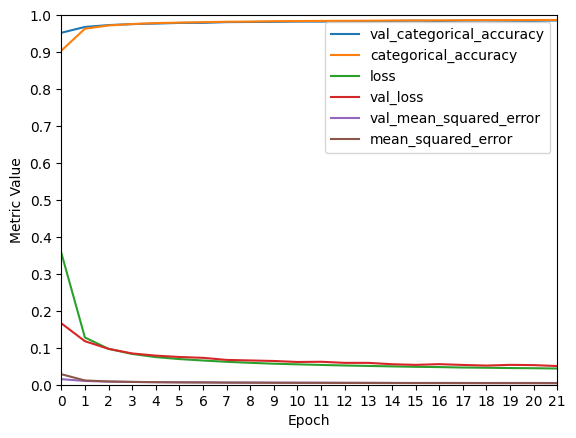

[0.04914751 0.00450585 0.98543154]


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
3727/3727 [==============================] - 31s 6ms/step - loss: 0.1748 - mean_squared_error: 0.0138 - categorical_accuracy: 0.9544 - val_loss: 0.1182 - val_mean_squared_error: 0.0107 - val_categorical_accuracy: 0.9666
Epoch 2/30
3727/3727 [==============================] - 10s 3ms/step - loss: 0.0884 - mean_squared_error: 0.0082 - categorical_accuracy: 0.9738 - val_loss: 0.0867 - val_mean_squared_error: 0.0082 - val_categorical_accuracy: 0.9733
Epoch 3/30
3727/3727 [==============================] - 11s 3ms/step - loss: 0.0786 - mean_squared_error: 0.0072 - categorical_accuracy: 0.9771 - val_loss: 0.0965 - val_mean_squared_error: 0.0089 - val_categorical_accuracy: 0.9724
Epoch 4/30
3727/3727 [==============================] - 11s 3ms/step - loss: 0.0766 - mean_squared_error: 0.0071 - categorical_accuracy: 0.9771 - val_loss: 0.0824 - val_mean_squared_error: 0.0076 - val_categorical_accuracy: 0.9753
Epoch 5/30
3727/3727 [==============================] - 10s 3ms/step - loss:

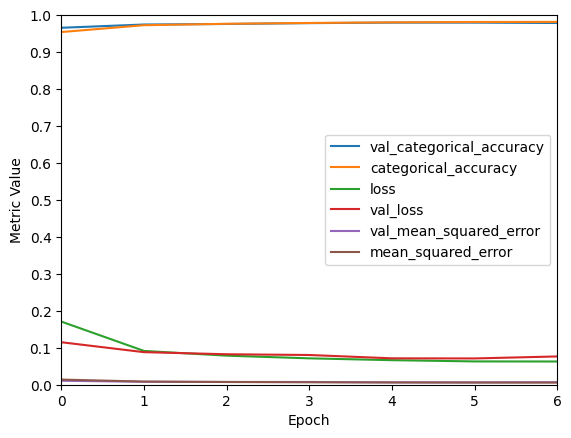

[0.06620258 0.00608824 0.98068606]


In [16]:
history,models_acc=runModeldeep2(metric_for_test,0.001,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModeldeep2(metric_for_test,0.01,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModeldeep2(metric_for_test,0.1,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))

history,models_acc=runModeldeep3(metric_for_test,0.001,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModeldeep3(metric_for_test,0.01,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))
history,models_acc=runModeldeep3(metric_for_test,0.1,0.6)
plot_avg_metrics(history)
print(np.mean(models_acc,axis=0))